# Flujo de Tarea

1 - Tenemos un listado de clientes 

2 - Cada cliente tiene sus stocks en cartera

3 - Nuestra misión es:
    
    * Leer ese listado
    * Ver para cada cliente si alguno de sus activos esta entrando en bear-mkt
    * En caso afirmativo:
        * Preparar reporte de opciones en un rango dado de vencimientos 
        * Mandarle un mail avisando potencial bearMkt y adjuntarle listado de coberturas
    * A todos los clientes:
        * Mandar un reporte semanal con info de su cartera (ej: variaciones semanales y mensuales por activo)
        * Adjuntar un gráfico en el mail con variacion de sus activos en base100 ultimos 30 días
    * Guardar en carpeta de cada cliente todos los reportes separados (el texto, la imagen, el excel de coberturas)
    * Enviar un mail con el texto, la imagen y los excels de coberturas al cliente
    * Guardar un ZIP en la carpeta del cliente con todos lo enviado por email, por fecha
    * Borrar los excels sueltos que habiamos guardado para enviar el email
    

<img src="imagenes/diagrama_de_flujo.svg" width=800>

## Leer listado de clientes

### Ver path actual

In [1]:
import os

os.getcwd()

'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant'

### Crear Directorio

In [3]:
# Me estoy refiriendo a una ruta relativa
if not os.path.exists('clase_backoffice'):
    os.mkdir('clase_backoffice')
else:
    print('el directorio ya existe en el path:')
    path = os.getcwd()
    print(path)

el directorio ya existe en el path:
C:\Users\Usuario\Desktop\cursos_2021\PreQuant


### Ir a directorio determinado

In [4]:
os.getcwd()

'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant'

In [5]:
if os.path.exists('clase_backoffice'):
    os.chdir("clase_backoffice")
    print('Nos movimos al directorio:')
    path = os.getcwd()
    print(path)    
else:
    print('El directorio no existe en el path actual:')
    path = os.getcwd()
    print(path)

Nos movimos al directorio:
C:\Users\Usuario\Desktop\cursos_2021\PreQuant\clase_backoffice


In [6]:
os.getcwd()

'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant\\clase_backoffice'

In [7]:
clientes = [{'nombre':'cliente_1', 'email':'clasespython2020@gmail.com', 'stocks':'AAPL,FB'},
            {'nombre':'cliente_2', 'email':'clasespython2020@gmail.com', 'stocks':'AMZN,NFLX,JPM'},
            {'nombre':'cliente_3', 'email':'clasespython2020@gmail.com', 'stocks':'KO,PG,VZ'}
           ]

In [8]:
import pandas as pd

pd.DataFrame(clientes).to_excel('clientes.xlsx',index=False)

### Retroceder directorio

In [9]:
os.getcwd()

'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant\\clase_backoffice'

In [10]:
os.chdir('..')

In [11]:
os.getcwd()

'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant'

### Ahora si voy a leer listado

In [13]:
import pandas as pd

directorio = r'C:\Users\Usuario\Desktop\cursos_2021\PreQuant\clase_backoffice'
directorio = 'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant\\clase_backoffice'
directorio = 'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice'

os.chdir(directorio)
clientes = pd.read_excel("clientes.xlsx", index_col='nombre')
clientes

,email,stocks
nombre,,
cliente_1,clasespython2020@gmail.com,"AAPL,FB"
cliente_2,clasespython2020@gmail.com,"AMZN,NFLX,JPM"
cliente_3,clasespython2020@gmail.com,"KO,PG,VZ"


### Para cada cliente armo una lista de activos

In [14]:
stocks = {}
emails = {}

for cliente in clientes.index.values:
    stocks[cliente] = clientes.loc[cliente,'stocks'].split(',')
    emails[cliente] = clientes.loc[cliente,'email']
    
stocks

{'cliente_1': ['AAPL', 'FB'],
 'cliente_2': ['AMZN', 'NFLX', 'JPM'],
 'cliente_3': ['KO', 'PG', 'VZ']}

In [15]:
emails

{'cliente_1': 'clasespython2020@gmail.com',
 'cliente_2': 'clasespython2020@gmail.com',
 'cliente_3': 'clasespython2020@gmail.com'}

In [19]:
for cliente, activos in stocks.items():
    print(f"El cliente {cliente} tiene los activos: {activos}")

El cliente cliente_1 tiene los activos: ['AAPL', 'FB']
El cliente cliente_2 tiene los activos: ['AMZN', 'NFLX', 'JPM']
El cliente cliente_3 tiene los activos: ['KO', 'PG', 'VZ']


## Preparar datos

En este caso, voy a leer data historica de cada activo y calcular 

    * La volatilidad histórica (usaremos 40 ruedas)
    * La variación % ultimos 7 días y 30 días

Condición para mandar reporte con puts sugeridos:

    * variación semanal es menor a -2%
    * variación mensual menor a -5%

Puts sugeridos:

    * Vencimientos de 20 a 90 días
    * Volatilidad implícita menor a la 2 * histórica en 40 ruedas

In [20]:
import requests
import pandas as pd

c_key = "NYF6LZZITQAOCYNQHYUZOJF4XGDPT0KK"

In [21]:
def getHist(symbol, periodT='day', period=1, freqT='minute', freq=1, na='true'):
    
    params = {'symbol':symbol, 'periodType':periodT, 'period':period, 
              'apikey' : c_key, 'frequencyType':freqT, 'frequency':freq ,
              'needExtendedHoursData':na}
    
    url_base='https://api.tdameritrade.com/v1/marketdata/'
    
    endpoint = url_base + symbol+'/pricehistory'
    
    r = requests.get(url=endpoint, params=params)  # data, json
    try:
        js = r.json()['candles']
        df = pd.DataFrame(js)
        df['fecha'] = pd.to_datetime(df.datetime - 3600*1000*3, unit='ms')
        df = df.set_index('fecha')
    except:
        print('Error, ojo que tenemos una rta inesperada', r.json())
        df = pd.DataFrame()
        
    return df

In [22]:
def options(symbol, days_f=0, days_t=0):
    params = {'apikey' : c_key, 'symbol':symbol}
    endpoint = 'https://api.tdameritrade.com/v1/marketdata/chains'
    r = requests.get(url=endpoint ,params=params)
    
    chain = r.json()
    v_calls = list(chain['callExpDateMap'].values())
    v_calls_fechas = list(chain['callExpDateMap'].keys())
    v_puts = list(chain['putExpDateMap'].values())
    v_puts_fechas = list(chain['putExpDateMap'].keys())

    calls = []
    for i in range(len(v_calls)):
        v = list(v_calls[i].values())    
        for j in range(len(v)):
            calls.append(v[j][0])

    puts = []
    for i in range(len(v_puts)):
        v = list(v_puts[i].values())    
        for j in range(len(v)):
            puts.append(v[j][0])

    contracts = pd.concat([pd.DataFrame(calls),pd.DataFrame(puts)])    
            
    if (days_f > 0) & (days_t)>0:
        try:
            contracts = contracts.loc[(contracts.daysToExpiration > days_f) & (contracts.daysToExpiration < days_t)]

        except:
            print(f"ERROR: {symbol} \n {contracts}")

    
    try:
        contracts = contracts.loc[:,['strikePrice','daysToExpiration','putCall','bid','ask',
                             'last','volatility','openInterest', 'theoreticalOptionValue',
                              'delta', 'gamma', 'theta', 'vega', 'rho']]

        contracts.columns = ['Strike','Dias','Tipo','Bid','Ask', 'Ultimo','VI','OpenInt','PrimaT', 
                             'delta', 'gamma', 'theta', 'vega', 'rho']

    except:
        print(f"ERROR: {symbol} \n {contracts}")
        
    return contracts

In [23]:
data = getHist('GGAL', periodT='year', period=1, freqT='daily', freq=1, na='false')
data['VH'] = data.close.pct_change().rolling(40).std() * 250**0.5 *100
data['v_semanal'] = (data.close / data.close.shift(5) - 1) *100 
data['v_mensual'] = (data.close / data.close.shift(30) - 1) *100
data = data.round(2)

vh, v_semanal, v_mensual = data.iloc[-1,-3:]
vh, v_semanal, v_mensual

(44.81, -6.44, 19.77)

In [25]:
contracts = options('GGAL')
contracts

,Strike,Dias,Tipo,Bid,Ask,Ultimo,VI,OpenInt,PrimaT,delta,gamma,theta,vega,rho
0,2.5,24,CALL,7.10,7.30,0.00,256.787,0,7.24,1,0,0,0.000,0
1,5.0,24,CALL,4.60,4.80,4.40,132.04,271,4.74,1,0,0,0.000,0
2,7.5,24,CALL,2.05,2.65,2.65,74.634,361,2.26,0.931,0.076,-0.003,0.003,0.001
3,10.0,24,CALL,0.30,0.35,0.40,46.93,3503,0.325,0.409,0.333,-0.008,0.010,0.002
4,12.5,24,CALL,0.00,0.20,0.06,76.728,1890,0.1,0.115,0.1,-0.007,0.005,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,10.0,577,PUT,2.65,3.00,2.50,55.462,324,2.825,-0.378,0.056,-0.002,0.046,-0.103
33,12.5,577,PUT,4.30,6.10,4.54,56.997,35,4.671,-0.495,0.057,-0.002,0.049,-0.15
34,15.0,577,PUT,4.80,7.60,6.51,53.307,2,6.492,-0.62,0.058,-0.002,0.046,-0.198
35,17.5,577,PUT,7.10,9.00,9.35,52.475,32,8.613,-0.71,0.053,-0.002,0.042,-0.246


In [33]:
import time
def prepararData(stocks):
    reportes = {}
    for cliente, stocks in stocks.items():
        reportes[cliente] = {}
        for i, stock in enumerate(stocks):
            print (f"Procesando Cliente: {cliente}, stock: {i+1}/{len(stocks)} {stock}     ", end='\r')
            data = getHist(stock, periodT='year', period=20, freqT='daily', freq=1, na='false')
            data['VH'] = data.close.pct_change().rolling(40).std() * 250**0.5 *100
            data['v_semanal'] = (data.close / data.close.shift(5) - 1) *100 
            data['v_mensual'] = (data.close / data.close.shift(30) - 1) *100
            data = data.round(2)
            base_100 = data.close.iloc[-30:] / data.close.iloc[-30] *100
            vh, v_semanal, v_mensual = data.iloc[-1,-3:]

            # Busco opciones entre plazos establecidos
            contracts = options(stock, days_f=20, days_t=90)
                                
            condicion = (v_semanal < -2) | (v_mensual < -5)
            coberturas = contracts if condicion else pd.DataFrame()
            
            
            reportes[cliente][stock] = {'v_semanal':v_semanal, 'v_mensual':v_mensual, 'base_100':base_100,
                                        'VH':vh,'cubrir': condicion, 'opciones':coberturas}
            
            time.sleep(0.5)
    return reportes

In [34]:
reportes = prepararData(stocks)

In [39]:
reportes['cliente_3']

{'KO': {'v_semanal': -2.14,
  'v_mensual': -0.28,
  'base_100': fecha
  2021-05-10 02:00:00    100.000000
  2021-05-11 02:00:00     98.925514
  2021-05-12 02:00:00     98.415589
  2021-05-13 02:00:00     99.271535
  2021-05-14 02:00:00     99.672191
  2021-05-17 02:00:00     99.508286
  2021-05-18 02:00:00     98.961938
  2021-05-19 02:00:00     98.652340
  2021-05-20 02:00:00     99.526498
  2021-05-21 02:00:00     99.471863
  2021-05-24 02:00:00     99.799672
  2021-05-25 02:00:00     99.781461
  2021-05-26 02:00:00    100.218539
  2021-05-27 02:00:00    101.056274
  2021-05-28 02:00:00    100.692042
  2021-06-01 02:00:00    100.673830
  2021-06-02 02:00:00    101.074486
  2021-06-03 02:00:00    101.329448
  2021-06-04 02:00:00    102.422145
  2021-06-07 02:00:00    102.057913
  2021-06-08 02:00:00    101.347660
  2021-06-09 02:00:00    101.038062
  2021-06-10 02:00:00    101.821162
  2021-06-11 02:00:00    102.276452
  2021-06-14 02:00:00    101.165544
  2021-06-15 02:00:00    100.9

## Carpetas por Cliente

In [40]:
import datetime

def prepararCarpetas(reportes):
    hoy = datetime.date.today().isoformat()

    for cliente, reporte in reportes.items():
        bases_100 = []

        print(cliente)

        if not os.path.exists(cliente):
            os.mkdir(cliente)

        os.chdir(cliente)

        texto = f"Estimado cliente {cliente}\n"
        texto += f"Reporte semanal preparado: {hoy} \n\n"


        for stock, rep in reporte.items():
            bases_100.append(rep['base_100'])

            if rep['cubrir']:
                texto += f"\nSu activo {stock} se encuentra en riesgo bajista,"
                texto += " le adjuntamos una lista de opciones posibles para que piense estrategia de cobertura"

                if len(rep['opciones']) > 0:
                    rep['opciones'].to_excel(f'{hoy}_{stock}.xlsx')

            else:
                texto += f"Su activo {stock} no se encuentra en riesgo bajista,"
                texto += f" presenta una variacion semanal del {rep['v_semanal']}%"
                texto += f" y una variacion mensual del {rep['v_mensual']}% \n"

        portafolio = pd.concat(bases_100, axis=1)
        portafolio.columns = reporte.keys()

        base_100_img = pd.DataFrame(portafolio).plot().get_figure()
        base_100_img.savefig(f'portafolio_{hoy}.jpg')

        with open(f'email_{hoy}.txt', 'w') as f:
            f.write(texto)

        os.chdir('..')

cliente_1
cliente_2
cliente_3


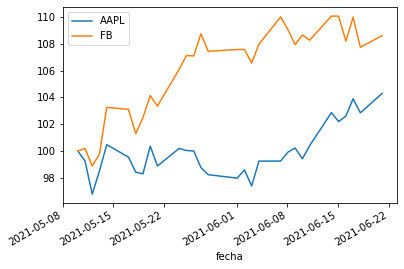

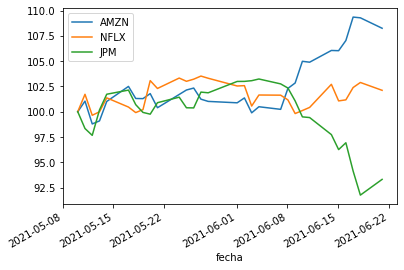

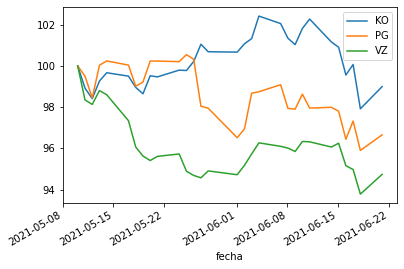

In [41]:
prepararCarpetas(reportes)

## Envio de emails

### Autorizacion de uso de scripting para la cuenta de gmail

https://myaccount.google.com/lesssecureapps

### Envio de emails simples

In [42]:
os.chdir(r'C:\Users\Usuario\Desktop\cursos_2021\PreQuant')
from gmail_password import *

os.chdir(r'C:\Users\Usuario\Desktop\cursos_2021\PreQuant\clase_backoffice')

In [43]:
import smtplib

remitente = "clasespython2020@gmail.com"
#gmail_password = 'mi_clave_correo_remitente'

destinatario = "clasespython2020@gmail.com"

In [46]:
file = r'C:\Users\Usuario\Desktop\cursos_2021\PreQuant\clase_backoffice\cliente_2\email_2021-06-22.txt'
with open(file) as f:
    lines = f.readlines()

text = ''.join(lines)
text

'Estimado cliente cliente_2\nReporte semanal preparado: 2021-06-22 \n\nSu activo AMZN no se encuentra en riesgo bajista, presenta una variacion semanal del 2.07% y una variacion mensual del 4.93% \nSu activo NFLX no se encuentra en riesgo bajista, presenta una variacion semanal del -0.58% y una variacion mensual del -1.36% \n\nSu activo JPM se encuentra en riesgo bajista, le adjuntamos una lista de opciones posibles para que piense estrategia de cobertura'

In [47]:
hoy = datetime.date.today().isoformat()

# Instancio el objeto de conexión al server de gmail
server = smtplib.SMTP("smtp.gmail.com", 587)

# inicio sesión segura
server.starttls()

# Me logueo con las credenciales
server.login(remitente, gmail_password)


for cliente, reporte in reportes.items():    
    file = f'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice/{cliente}/email_{hoy}.txt'
    with open(file) as f:
        lines = f.readlines()

    body = ''.join(lines)
    subject = f'Hola, {cliente} Reporte Curso Ucema {hoy}'

    print(f"Enviando mensaje a: {cliente}")

    msg = f'Subject: {subject}\n\n{body}'

    # Envío el email
    server.sendmail(remitente, destinatario, msg)


# Cierro la conexión
server.quit()

Enviando mensaje a: cliente_1
Enviando mensaje a: cliente_2
Enviando mensaje a: cliente_3


(221, b'2.0.0 closing connection q3sm2647149qkn.15 - gsmtp')

### Leer archivos de un directorio

In [56]:
cliente = 'cliente_2'
os.chdir(f'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice/{cliente}')


archivos = []
for x in os.scandir():
    if not x.is_dir():
        
        nombre = x.name
        extension = nombre.split('.')[-1]
        
        if extension != "zip":
            archivos.append(nombre)
        
archivos

['2021-06-22_JPM.xlsx', 'email_2021-06-22.txt', 'portafolio_2021-06-22.jpg']

In [53]:
x.stat().st_size / 1024

29.033203125

In [24]:
cliente = 'cliente_2'
os.chdir(f'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice/{cliente}')

archivos = [x.name for x in os.scandir() if not x.is_dir()]
archivos

['2021-06-20_JPM.xlsx', 'email_2021-06-20.txt', 'portafolio_2021-06-20.jpg']

### Envio de Emails con Adjuntos

In [57]:
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import smtplib

In [58]:
def enviarEamils(reportes, emails):
    # Inicio Sesion
    session = smtplib.SMTP('smtp.gmail.com:587') 
    session.ehlo()
    session.starttls() 
    session.login(remitente, gmail_password) 

    for cliente, reporte in reportes.items():    
        file = f'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice/{cliente}/email_{hoy}.txt'
        with open(file) as f:
            lines = f.readlines()

        body = ''.join(lines)
        subject = f'Hola, {cliente} Reporte Curso Ucema {hoy}'

        print(f"Enviando mensaje a: {cliente}")


        # Preparo mensaje
        message = MIMEMultipart()
        message['From'] = remitente
        message['To'] = emails[cliente]
        message['Subject'] = subject
        mail_content = body

        message.attach(MIMEText(mail_content, 'plain'))

        # Adjunto los archivos que quiera
        os.chdir(f'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice/{cliente}/')
        archivos = [x.name for x in os.scandir() if not x.is_dir()]

        for archivo in archivos:    
            file = open(archivo, 'rb') 
            payload = MIMEBase('application', 'octate-stream')
            payload.set_payload((file).read())
            encoders.encode_base64(payload) 
            payload.add_header('Content-Disposition', 'attachment; filename="'+archivo+'"')
            message.attach(payload)

        # Envio el email 
        session.sendmail(remitente, destinatario, message.as_string())

    # Cierro Sesion
    session.quit()

In [59]:
enviarEamils(reportes, emails)

Enviando mensaje a: cliente_1
Enviando mensaje a: cliente_2
Enviando mensaje a: cliente_3


## Compresión

In [63]:
import zipfile
import os

def compress(file_names):
    path = os.getcwd()
    hoy = datetime.date.today().isoformat()
    zf = zipfile.ZipFile(f"comprimido_{hoy}.zip", mode="w")
    for file_name in file_names:
        zf.write(path +'\\'+ file_name, file_name, compress_type=zipfile.ZIP_DEFLATED)
    zf.close()

def comprimirEliminar(reportes):
    for cliente in reportes.keys():    
        os.chdir(f'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice/{cliente}/')
        
        # esto lo tienen que cambiar por el for que evita borrar los zips
        archivos = [x.name for x in os.scandir() if not x.is_dir()]
        
        compress(archivos)
        for archivo in archivos:        
            extension = archivo.split('.')[-1]
            if extension != "zip":
                os.remove(archivo)

In [64]:
comprimirEliminar(reportes)

# Todo con funciones

In [65]:
os.getcwd()

'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant\\clase_backoffice\\cliente_3'

In [66]:
os.chdir('..')
os.getcwd()

'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant\\clase_backoffice'

In [67]:
clientes = [{'nombre':'oso', 'email':'clasespython2020@gmail.com', 'stocks':'TSLA'},
                    {'nombre':'juanfer', 'email':'clasespython2020@gmail.com', 'stocks':'AAL,DAL'},
                    {'nombre':'pity', 'email':'clasespython2020@gmail.com', 'stocks':'PFE'}
                   ]


pd.DataFrame(clientes).to_excel('clientes.xlsx', index=False)



clientes = pd.read_excel("clientes.xlsx", index_col='nombre')

stocks, emails = {}, {}
for cliente in clientes.index.values:
    stocks[cliente] = clientes.loc[cliente,'stocks'].split(',')
    emails[cliente] = clientes.loc[cliente,'email']
    
stocks, emails

({'oso': ['TSLA'], 'juanfer': ['AAL', 'DAL'], 'pity': ['PFE']},
 {'oso': 'clasespython2020@gmail.com',
  'juanfer': 'clasespython2020@gmail.com',
  'pity': 'clasespython2020@gmail.com'})

osocesando Cliente: pity, stock: 1/1 PFE        
juanfer
pity
Enviando mensaje a: oso
Enviando mensaje a: juanfer
Enviando mensaje a: pity


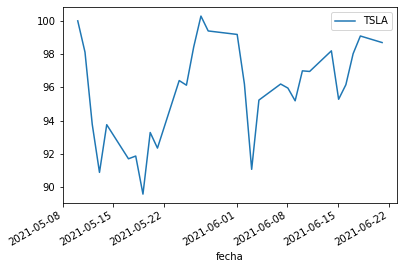

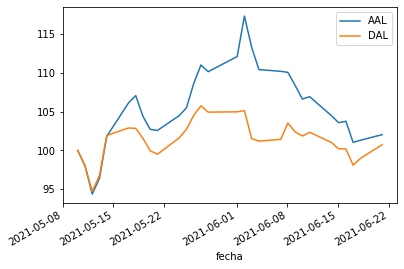

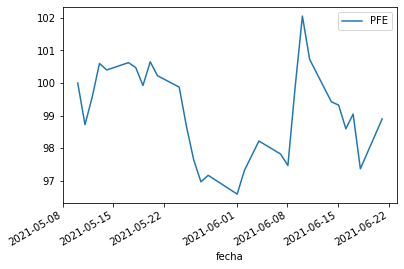

In [68]:
reportes = prepararData(stocks)
prepararCarpetas(reportes)
enviarEamils(reportes, emails)
comprimirEliminar(reportes)

# Plus: Leer bandeja y buscar

In [70]:
import imaplib

imap_ssl_host = 'imap.gmail.com'
server = imaplib.IMAP4_SSL(imap_ssl_host)
server.login('clasespython2020@gmail.com', gmail_password)

('OK', [b'clasespython2020@gmail.com authenticated (Success)'])

In [72]:
server.select('Inbox')
status, nums = server.search(None, 'ALL')

In [74]:
nums

[b'1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56']

In [75]:
print(nums[0].decode().split())

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56']


In [76]:
import imaplib
import pandas as pd

def leerCarpeta(cuenta, gmail_password, limit=10, carpeta='Inbox', query='ALL', order='DESC'):

    imap_ssl_host = 'imap.gmail.com'
    server = imaplib.IMAP4_SSL(imap_ssl_host)
    server.login(cuenta, gmail_password)

    server.select(carpeta)
    status, nums = server.search(None, query)

    count = 0
    results = []
    
    if order == 'DESC':
        emails = nums[0].split()[::-1]
    else:
        emails = nums[0].split()
        
    for num in emails:

        count += 1
        status, data = server.fetch(num, '(BODY.PEEK[HEADER])')
        email = data[0][1].decode().split('\r\n')

        r = {}
        for line in email:
            for clave in ['Subject', 'Date', 'From']:
                if line.find(clave) == 0:
                    r[clave] = line[len(clave)+2:]
        results.append(r)

        if count == limit:
            break

    return pd.DataFrame(results)

In [77]:
leerCarpeta('clasespython2020@gmail.com', gmail_password, limit=10, carpeta='Inbox', query='ALL')

,Date,From,Subject
0,"Tue, 22 Jun 2021 16:48:04 -0700 (PDT)",clasespython2020@gmail.com,"Hola, pity Reporte Curso Ucema 2021-06-22"
1,"Tue, 22 Jun 2021 16:48:02 -0700 (PDT)",clasespython2020@gmail.com,"Hola, juanfer Reporte Curso Ucema 2021-06-22"
2,"Tue, 22 Jun 2021 16:47:58 -0700 (PDT)",clasespython2020@gmail.com,"Hola, oso Reporte Curso Ucema 2021-06-22"
3,"Tue, 22 Jun 2021 16:37:03 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_3 Reporte Curso Ucema 2021-06-22"
4,"Tue, 22 Jun 2021 16:37:01 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_2 Reporte Curso Ucema 2021-06-22"
5,"Tue, 22 Jun 2021 16:36:59 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_1 Reporte Curso Ucema 2021-06-22"
6,"Tue, 22 Jun 2021 16:17:04 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_3 Reporte Curso Ucema 2021-06-22"
7,"Tue, 22 Jun 2021 16:17:03 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_2 Reporte Curso Ucema 2021-06-22"
8,"Tue, 22 Jun 2021 16:17:02 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_1 Reporte Curso Ucema 2021-06-22"
9,"Sun, 20 Jun 2021 05:45:52 GMT",Google <no-reply@accounts.google.com>,=?UTF-8?Q?Alerta_de_seguridad_cr=C3=ADtica?=


In [78]:
leerCarpeta('clasespython2020@gmail.com', gmail_password, limit=10, carpeta='Inbox', query='(SEEN BODY UCEMA)')

,Date,From,Subject
0,"Tue, 22 Jun 2021 16:48:02 -0700 (PDT)",clasespython2020@gmail.com,"Hola, juanfer Reporte Curso Ucema 2021-06-22"
1,"Tue, 22 Jun 2021 16:37:01 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_2 Reporte Curso Ucema 2021-06-22"
2,"Tue, 22 Jun 2021 16:17:02 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_1 Reporte Curso Ucema 2021-06-22"


In [79]:
leerCarpeta('clasespython2020@gmail.com', gmail_password, limit=10, carpeta='Inbox', 
            query='(NOT SEEN TO clasespython2020@gmail.com)')

,Date,From,Subject
0,"Tue, 22 Jun 2021 16:48:04 -0700 (PDT)",clasespython2020@gmail.com,"Hola, pity Reporte Curso Ucema 2021-06-22"
1,"Tue, 22 Jun 2021 16:47:58 -0700 (PDT)",clasespython2020@gmail.com,"Hola, oso Reporte Curso Ucema 2021-06-22"
2,"Tue, 22 Jun 2021 16:37:03 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_3 Reporte Curso Ucema 2021-06-22"
3,"Tue, 22 Jun 2021 16:36:59 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_1 Reporte Curso Ucema 2021-06-22"
4,"Tue, 22 Jun 2021 16:17:04 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_3 Reporte Curso Ucema 2021-06-22"
5,"Tue, 22 Jun 2021 16:17:03 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_2 Reporte Curso Ucema 2021-06-22"
6,"Sun, 20 Jun 2021 05:45:52 GMT",Google <no-reply@accounts.google.com>,=?UTF-8?Q?Alerta_de_seguridad_cr=C3=ADtica?=
7,"Thu, 10 Jun 2021 20:43:10 -0500","""Finbox"" <manuel.bleve@finbox.com>",There is a theme amongst top performing companies
8,"Tue, 08 Jun 2021 20:41:09 -0500","""Finbox"" <manuel.bleve@finbox.com>",Ideas From Top Portfolios To Help You
9,"Sun, 06 Jun 2021 20:38:50 -0500","""Finbox"" <manuel.bleve@finbox.com>",Wise Words From The Oracle


In [80]:
leerCarpeta('clasespython2020@gmail.com', gmail_password, limit=1, carpeta='Inbox', 
            query='(SENTBEFORE 01-nov-2020)')

,Date,From,Subject
0,"Sun, 25 Oct 2020 13:39:11 -0700 (PDT)",clasespython2020@gmail.com,Cryptos correlation para scalping


## Mas queries

https://datatracker.ietf.org/doc/html/rfc3501.html#section-6.4.4